In [1]:
import os
import glob
import numpy as np  # linear algebra
import cupy as cp   # parallelelize numpy to utilize GPU
import pandas as pd
import matplotlib.pyplot as plt

from skimage.transform import resize

plt.rcParams.update({'font.size': 12})

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing

In [3]:
def read_pgm(file):
    """Return a raster of integers from a PGM as a list of lists."""
    pgmf = open(file, 'rb')
    assert pgmf.readline() == b'P5\n'
    (width, height) = [int(i) for i in pgmf.readline().split()]
    depth = int(pgmf.readline())
    assert depth <= 255

    raster = []
    for y in range(height):
        row = []
        for y in range(width):
            row.append(ord(pgmf.read(1)))
        raster.append(row)
    raster = np.array(raster)
    return raster

In [6]:
cropped_path = "/content/drive/My Drive/School/Archive/AMATH584/repos/amath584/hw3/data/yalefaces_cropped/CroppedYale/"
sub_dirs = os.listdir(cropped_path)

person_image_count = {} # track how many images we have for each person
person_image_indices = {} # track the image indices for each person
files = []
cumsum = 0
for sub_dir in sub_dirs:
  image_paths = glob.glob(f"{cropped_path}/{sub_dir}/*")
  files.append(image_paths)
  person_id = sub_dir[-3:]
  count = len(image_paths)
  person_image_count[person_id] = count
  person_image_indices[person_id] = (cumsum, cumsum+count)
  cumsum += count

files = [file for sublist in files for file in sublist]

In [7]:
print(f"There are a total of {len(files)} images")

There are a total of 2432 images


Read in all 2432 faces into a matrix so that each column is one face.

In [8]:
all_faces = []
for file in files:
  mat = read_pgm(file)
  all_faces.append(mat.flatten())

all_faces = np.transpose(np.vstack(all_faces))

In [9]:
# plot the average face of each individual
person_avg_faces = {}
for x, index in sorted(person_image_indices.items()):
  person_avg_faces[x] = all_faces[:, index[0]:index[1]].mean(axis=1)

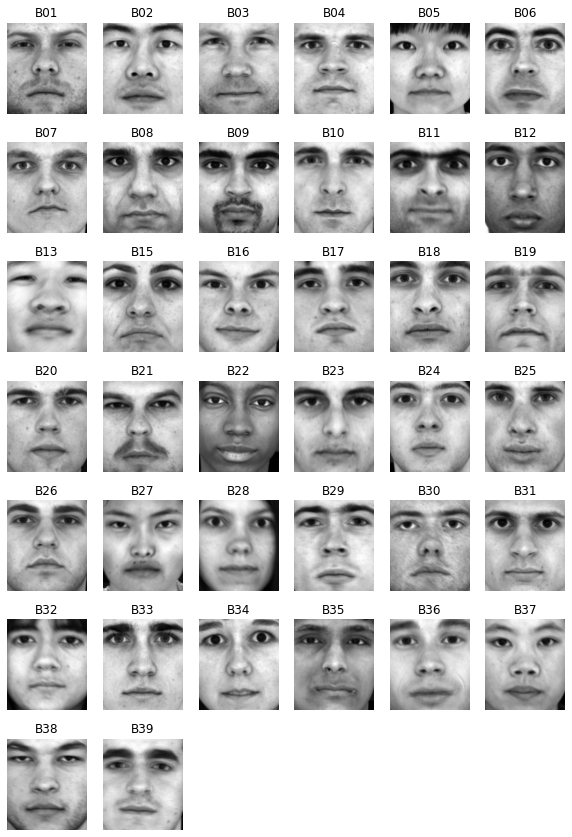

In [10]:
plt.figure(figsize=(10,15))

for i, face in enumerate(sorted(person_avg_faces.items())):
  plt.subplot(7, 6, i+1)
  plt.imshow(face[1].reshape(192,168), plt.cm.gray)
  plt.axis('off')
  plt.title(f'{face[0]}')

To validate our PCA using the first $r$ principal components, we first split our dataset in a training and testing dataset. We leave out images for individuals B09 and B22.

In [11]:
b09_indices = person_image_indices["B09"]
b22_indices = person_image_indices["B22"]
test_indices = list(range(b09_indices[0],b09_indices[1])) + list(range(b22_indices[0],b22_indices[1]))
test = all_faces[:, test_indices]
train = np.delete(all_faces, test_indices, axis=1)

In [12]:
processed_path = "/content/drive/My Drive/School/Archive/AMATH584/repos/amath584/hw2/processed_data"

# np.save(f'{processed_path}/test.npy', test)
# np.save(f'{processed_path}/train.npy', train)

# test = np.load(f'{processed_path}/test.npy')
# train = np.load(f'{processed_path}/train.npy')

Subtract the average face from each image.

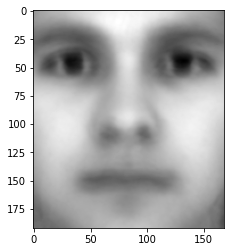

In [13]:
avg_face = train.mean(axis=1)
plt.imshow(avg_face.reshape(192,168), plt.cm.gray)

In [14]:
train_ms = train - np.tile(avg_face,(train.shape[1],1)).T

# (1) SVD/PCA Analysis

In [15]:
Uhat, Shat, Vhat = np.linalg.svd(train_ms, full_matrices=False)  # economy SVD

In [16]:
# save processed data so we do not have to recompute SVD

# np.save(f'{processed_path}/uhat.npy', Uhat)
# np.save(f'{processed_path}/shat.npy', Shat)
# np.save(f'{processed_path}/vhat.npy', Vhat)

# (2) Interpretation of $\hat{U}$, $\hat{\Sigma}$, and $\hat{V}$.

Plot first couple reshaped columns of $U$

In [17]:
def plot_eigenface(index):
  mat = Uhat[:,index].reshape(192,168)
  plt.imshow(mat, plt.cm.gray)
  plt.show()

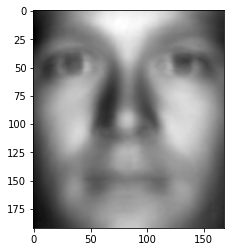

In [18]:
plot_eigenface(0)

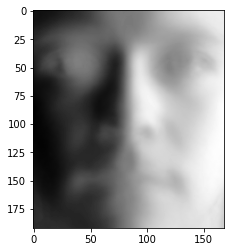

In [19]:
plot_eigenface(1)

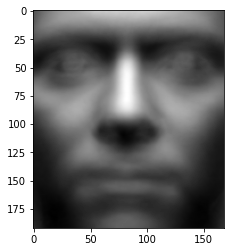

In [20]:
plot_eigenface(2)

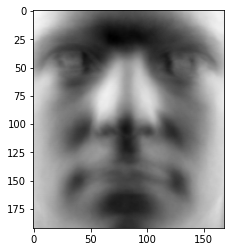

In [21]:
plot_eigenface(3)

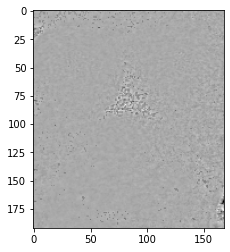

In [22]:
plot_eigenface(2302)

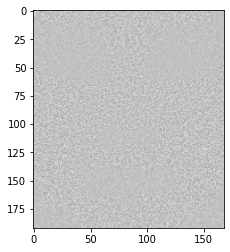

In [23]:
plot_eigenface(2303)

The columns of $\hat{U}$ are the eigenfaces (i.e., principal components). Mathematically, the eigenfaces are the eigenvectors of the covariance matrix $\frac{1}{n-1}X^*X$. In general, an eigenface is a "standard face" that can be used to reconstruct a general face. The first few eigenfaces all have general features of a human face such as eyes, a nose, and a mouth. The last two eigenfaces have the smallest variance of the original variables and look nothing like a human face.

# (3) Singular value spectrum

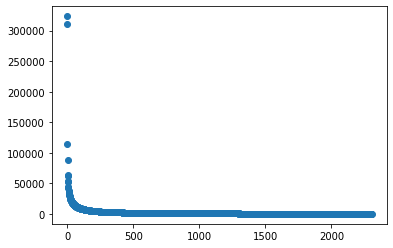

In [24]:
# singular value spectrum
plt.plot(Shat, linestyle="",marker="o")

In [25]:
red_indices = np.array([24, 49, 99, 199, 399, 799, 1599, 2303])
red_pt = Shat[red_indices,]
Shat_red = pd.DataFrame(np.array((red_indices + 1, red_pt)).T)

Text(0.5, 0, '$k$')

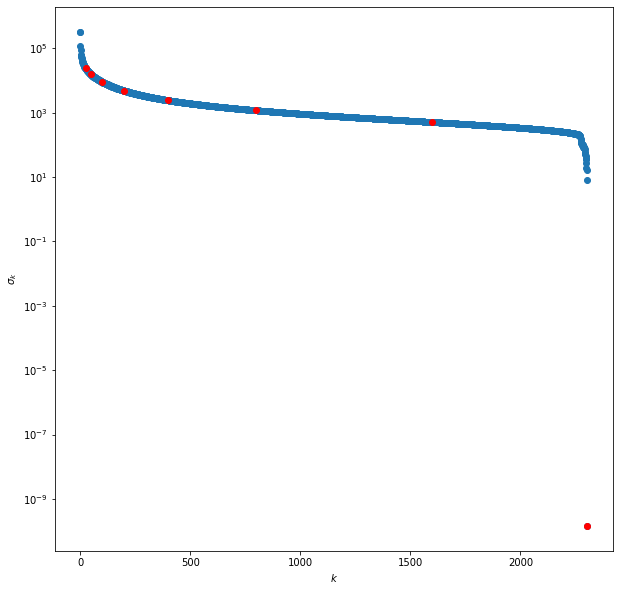

In [26]:
# singular value spectrum - log scale
plt.figure(figsize=(10,10))
plt.plot(Shat, linestyle="",marker="o")
plt.plot(Shat_red[0], Shat_red[1], linestyle="", marker="o", color="red")
plt.yscale("log")
plt.ylabel("$\sigma_k$")
plt.xlabel("$k$")

Drop singular values less than tolerance $10^{-5}$.

Text(0.5, 0, '$k$')

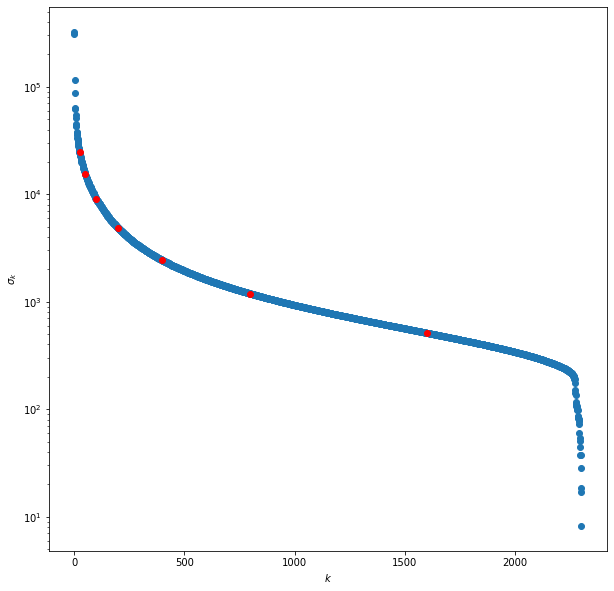

In [27]:
# singular value spectrum - log scale
tol = 10**(-5)
plt.figure(figsize=(10,10))
plt.plot(Shat[Shat > tol], linestyle="",marker="o")
plt.plot(Shat_red[0][Shat_red[1] > tol], Shat_red[1][Shat_red[1] > tol], linestyle="", marker="o", color="red")
plt.yscale("log")
plt.ylabel("$\sigma_k$")
plt.xlabel("$k$",   )

Text(0.5, 0, '$k$')

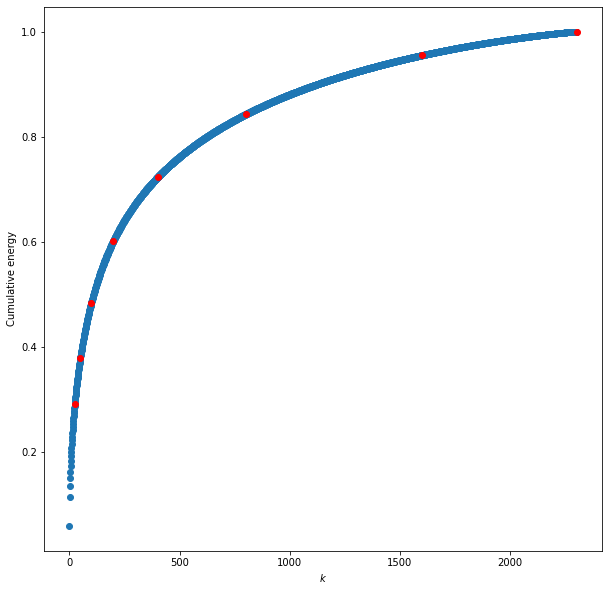

In [28]:
energy = np.cumsum(Shat) / np.sum(Shat)
red_energy = pd.DataFrame(np.array((red_indices + 1, energy[red_indices])).T)

plt.figure(figsize=(10,10))
plt.plot(energy, linestyle="",marker="o")
plt.plot(red_energy[0], red_energy[1], color= "red", linestyle="",marker="o")
plt.ylabel("Cumulative energy")
plt.xlabel("$k$")

In [29]:
energy[red_indices]

array([0.29150193, 0.37798082, 0.48333568, 0.60135671, 0.72252296,
       0.84270927, 0.95534781, 1.        ])

In [30]:
print(f"First singulare value: {Shat[0]} \n Last singular value: {Shat[-1]}")

First singulare value: 323580.80185814097 
 Last singular value: 1.4369866621484243e-10


In [31]:
Shat[(Shat == 0) | (Shat < tol)]

array([1.43698666e-10])

Since one singular values is sufficiently close to zero the rank of the face space is not full. 

### Low rank reconstruction


In [32]:
# convert to cupy to use GPU when doing matrix multiplication
Uhat = cp.asarray(Uhat)
test = cp.asarray(test)
avg_face = cp.asarray(avg_face)

In [33]:
test_ms = test - cp.tile(avg_face, (test.shape[1],1)).T

In [34]:
test_face = test.take(10, axis=1)
test_face_ms = test_face - avg_face

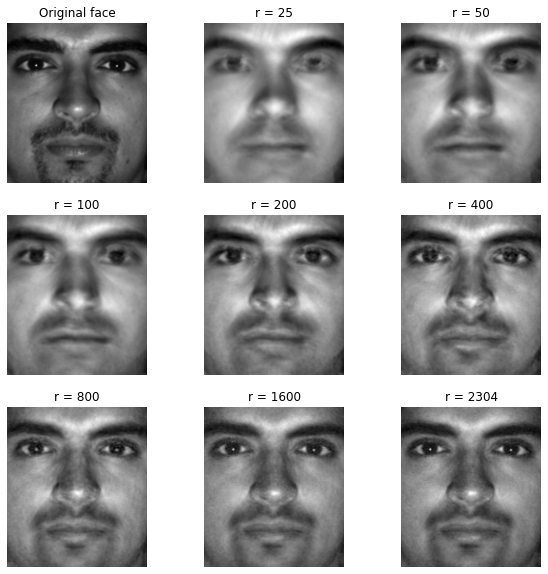

In [35]:
plt.figure(figsize=(10,10))

r_list = [25, 50, 100, 200, 400, 800, 1600, 2304]

plt.subplot(3,3,1)
plt.imshow(cp.asnumpy(test_face.reshape(192,168)), plt.cm.gray)
plt.axis('off')
plt.title(f'Original face')



for i, r in enumerate(r_list):
  recon_face = avg_face + Uhat[:,:r] @ Uhat[:,:r].T @ test_face_ms
  mat = recon_face.reshape(192,168)
  plt.subplot(3,3,i+2)
  plt.imshow(cp.asnumpy(mat), plt.cm.gray)
  plt.axis('off')
  plt.title(f'r = {r}')

Compute reconstruction error

In [36]:
mse_list = []

for r in r_list:
  recon_faces = cp.tile(avg_face, (128,1)).T + (Uhat[:,:r] @ Uhat[:,:r].T @ test_ms)
  mse = cp.mean(cp.square(recon_faces - test))
  mse_list.append(mse)

Text(0.5, 0, '$r$')

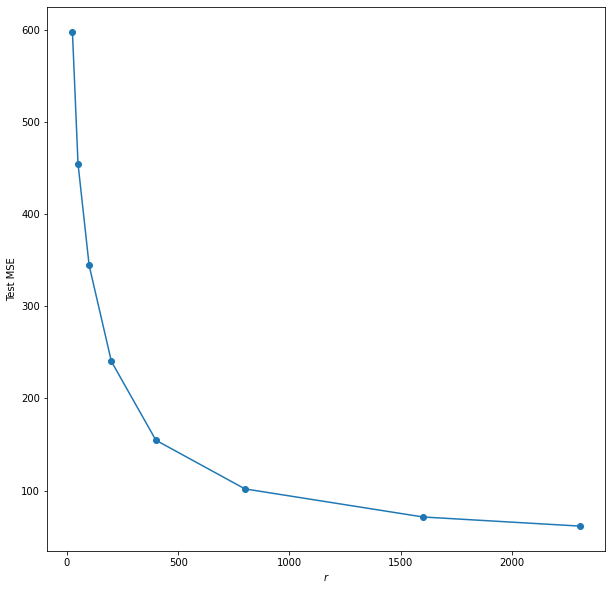

In [37]:
mse_df = pd.DataFrame(np.array((r_list, mse_list)).T)
plt.figure(figsize=(10,10))
plt.plot(mse_df[0], mse_df[1],marker="o")
plt.ylabel("Test MSE")
plt.xlabel("$r$")


# (4) Uncropped images

In [39]:
uncropped_path = "/content/drive/My Drive/School/Archive/AMATH584/repos/amath584/hw3/data/yalefaces/"
uncropped_files = [f for f in os.listdir(uncropped_path) if os.path.isfile(os.path.join(uncropped_path, f))]

# shape = (243, 320)
uncropped_faces = []
uncropped_subject_indices = {}
for i, file in enumerate(uncropped_files):
  mat = plt.imread(f"{uncropped_path}/{file}")
  uncropped_faces.append(mat.flatten())
  subject = file[0:9]
  if subject in uncropped_subject_indices:
    uncropped_subject_indices.get(subject).append(i)
  else:
    uncropped_subject_indices[subject] = [i]

uncropped_faces = np.transpose(np.vstack(uncropped_faces))

In [40]:
# plot the average face of each individual
subject_avg_faces = {}
for x, index in sorted(uncropped_subject_indices.items()):
  subject_avg_faces[x] = uncropped_faces[:, index].mean(axis=1)

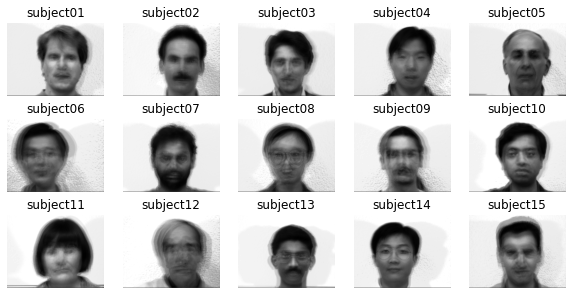

In [41]:
plt.figure(figsize=(10,5))

for i, face in enumerate(sorted(subject_avg_faces.items())):
  plt.subplot(3,5, i+1)
  plt.imshow(face[1].reshape(243, 320), plt.cm.gray)
  plt.axis('off')
  plt.title(f'{face[0]}')

Test on images from subject 11 and subject 15. Train on all other subjects.

In [42]:
s11_indices = uncropped_subject_indices["subject11"]
s15_indices = uncropped_subject_indices["subject15"]
test_indices = s11_indices + s15_indices
print(test_indices)
test = uncropped_faces[:, test_indices]
train = np.delete(uncropped_faces, test_indices, axis=1)

[109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163]


In [45]:
# np.save(f'{processed_path}/test_uncropped.npy', test)
# np.save(f'{processed_path}/train_uncropped.npy', train)

# test = np.load(f'{processed_path}/test_uncropped.npy')
# train = np.load(f'{processed_path}/train_uncropped.npy')

In [46]:
avg_face = train.mean(axis=1)
train_ms = train - np.tile(avg_face,(train.shape[1],1)).T
Uhat, Shat, Vhat = np.linalg.svd(train_ms, full_matrices=False)  # economy SVD

(-0.5, 319.5, 242.5, -0.5)

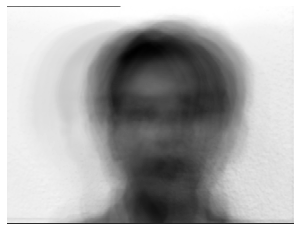

In [47]:
# average face
plt.imshow(avg_face.reshape(243,320), plt.cm.gray)
plt.axis('off')

In [48]:
def plot_eigenface_uncropped(index):
  mat = Uhat[:,index].reshape(243,320)
  plt.imshow(mat, plt.cm.gray)
  plt.show()

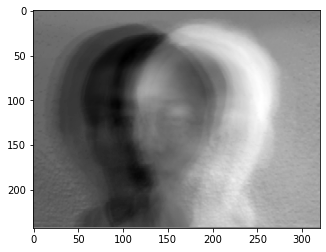

In [49]:
plot_eigenface_uncropped(0)

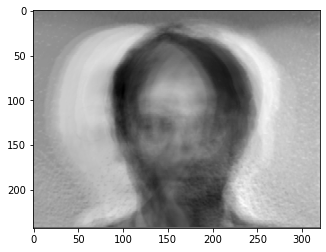

In [50]:
plot_eigenface_uncropped(1)

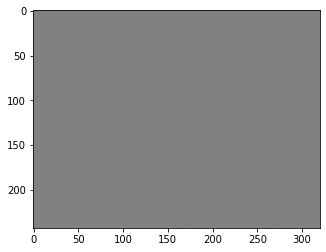

In [51]:
plot_eigenface_uncropped(142)

In [52]:
# np.save(f'{processed_path}/uhat_uncropped.npy', Uhat)
# np.save(f'{processed_path}/shat_uncropped.npy', Shat)
# np.save(f'{processed_path}/vhat_uncropped.npy', Vhat)

Text(0.5, 1.0, 'Singular Value Spectrum - log scale')

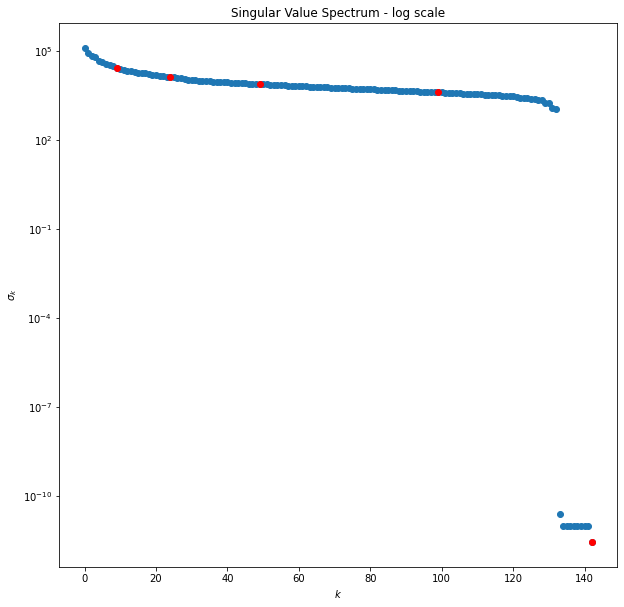

In [53]:
# singular value spectrum - log scale

r_list = np.array([9, 24, 49, 99, 142])
red_pt = Shat[r_list,]
Shat_red = pd.DataFrame(np.array((r_list, red_pt)).T)

plt.figure(figsize=(10,10))

plt.plot(Shat, linestyle="",marker="o")
plt.plot(Shat_red[0], Shat_red[1], linestyle="", marker="o", color="red")
plt.yscale("log")
plt.ylabel("$\sigma_k$")
plt.xlabel("$k$",   )
plt.title("Singular Value Spectrum - log scale")

In [54]:
tol = 10**(-10)
len(Shat[Shat < tol])

10

Text(0.5, 0, '$k$')

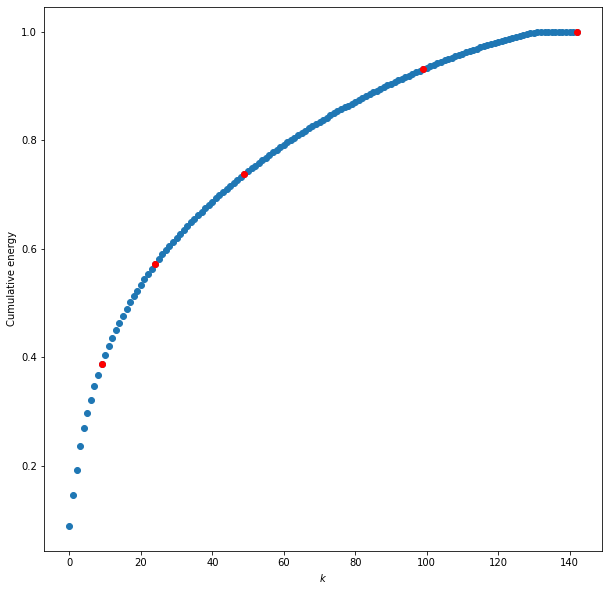

In [55]:
energy = np.cumsum(Shat) / np.sum(Shat)
red_energy = pd.DataFrame(np.array((r_list, energy[r_list])).T)

plt.figure(figsize=(10,10))
plt.plot(energy, linestyle="",marker="o")
plt.plot(red_energy[0], red_energy[1], color= "red", linestyle="",marker="o")
plt.ylabel("Cumulative energy")
plt.xlabel("$k$")

In [56]:
red_energy

,0,1
0,9.0,0.386860
1,24.0,0.571911
2,49.0,0.737659
3,99.0,0.931069
4,142.0,1.000000


In [57]:
Shat_red

,0,1
0,9.0,2.720602e+04
1,24.0,1.313036e+04
2,49.0,7.580666e+03
3,99.0,4.092403e+03
4,142.0,2.809679e-12


In [58]:
# convert to cupy to use GPU when doing matrix multiplication
Uhat = cp.asarray(Uhat)
test = cp.asarray(test)
avg_face = cp.asarray(avg_face)

In [59]:
test_ms = test - cp.tile(avg_face, (test.shape[1],1)).T

In [60]:
from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [62]:
# Since I don't have a lot of RAM, I'm multiplying the matrices in batches

r_list = [10, 25, 50, 100, 143]
batch_size = 10000  # number of rows to subset U by
batch = list(range(0,Uhat.shape[0], batch_size))
batch.append(Uhat.shape[0])

for r in r_list:
  print(r)
  for i, b in enumerate(pairwise(batch)):
    print(b)
    Uhat_sq = Uhat[b[0]:b[1],:r].dot(Uhat[:,:r].T)
    recon_test_batch = Uhat_sq.dot(test_ms)
    cp.save(f'{processed_path}/recon_test_{r}_batch_{i}.npy', recon_test_batch)

10
(0, 10000)


OutOfMemoryError: ignored

In [ ]:
def load_recon_test_face(r):
  recon_test_list = []
  for i in range(0, len(batch)-1):
    recon_sub = cp.load(f'{processed_path}/recon_test_{r}_batch_{i}.npy')
    recon_test_list.append(recon_sub)
  recon_test_ms = cp.vstack(recon_test_list)
  recon_test = recon_test_ms + cp.tile(avg_face, (recon_test_ms.shape[1],1)).T
  
  return recon_test

NameError: ignored

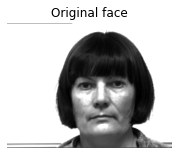

In [63]:
plt.figure(figsize=(10,10))

# choose int between 0 and 22
test_col = 5

test_face = test.take(test_col, axis=1)

plt.subplot(3,3,1)
plt.imshow(cp.asnumpy(test_face.reshape(243, 320)), plt.cm.gray)
plt.axis('off')
plt.title(f'Original face')

r_list = [10, 25, 50, 100, 143]

for i, r in enumerate(r_list):
  recon_face = load_recon_test_face(r)[:, test_col]
  mat = recon_face.reshape(243, 320)
  plt.subplot(3,3,i+2)
  plt.imshow(cp.asnumpy(mat), plt.cm.gray)
  plt.axis('off')
  plt.title(f'r = {r}')

Calculate reconstruction MSE

In [ ]:
mse_list = []

for r in r_list:
  recon_faces = load_recon_test_face(r)
  mse = cp.mean(cp.square(recon_faces - test))
  mse_list.append(mse)

In [ ]:
mse_df = pd.DataFrame(np.array((r_list, mse_list)).T)
plt.figure(figsize=(10,10))
plt.plot(mse_df[0], mse_df[1],marker="o")
plt.ylabel("Test MSE")
plt.xlabel("$r$")